# Introduction


Instead of multiclass regression models, the implementation attempted here is one versus rest classification.



In [ ]:
# references
# pieces of code adapted from w3schools.com, stackoverflow and geeksforgeeks.org

#import numpy and plot libraries
import numpy as np
from numpy import log,dot,e,shape
import copy, math
import matplotlib.pyplot as plt
import random
np.set_printoptions(precision=2)


In [ ]:
# this is loaded from a shared volume on collab - permissions are provided for your access.
dataLocation = "/content/drive/MyDrive/assignments/sem1/ml/assignment1/bezdekIris.data"

# # load this to a np dataset
featureSet = np.loadtxt(dataLocation, delimiter=",", usecols = (0,1,2,3))
labelSet = np.loadtxt(dataLocation, delimiter=",", usecols = (4), dtype=str)

def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

featureSet, labelSet = unison_shuffled_copies(featureSet, labelSet)

# keeping a copy
originalFeatureSet = featureSet[:]
originalLabelSet = labelSet[:]

The original dataset is loaded in to the memory. Shuffling and sorting to test, validate and test dataset is the next step to do.

In [ ]:
X_features = ['Sepal length','Sepal width','Petal length','Petal width']

# Splitting to the different samples - train, validate, test
splitRatio = [70, 20, 10] # sum should be 100% - otherwise will clip the array

X_train, X_validation, X_test = np.split(featureSet,
  [int(splitRatio[0]/100*len(featureSet)), int((splitRatio[0]+splitRatio[1])/100*len(featureSet)) ] )
y_train, y_validation, y_test = np.split(labelSet,
  [int(splitRatio[0]/100*len(labelSet)), int((splitRatio[0]+splitRatio[1])/100*len(labelSet)) ] )

Next step is to analyse the dataset to find outliers. Histograms and distribution graphs will help.


Measures of Dispersion
Minimum = 1.3
Maximum = 5.7
Range = 4.4
Variance = 2.631875
Standard Deviation = 1.6223054582907621


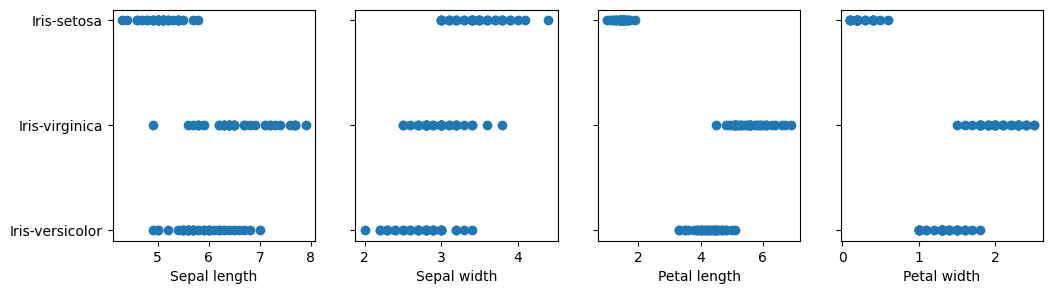

In [ ]:
## measures of dispersion
minInData = np.amin(X_train[0])
maxInData = np.amax(X_train[0])
rangeOfData = np.ptp(X_train[0])
varianceInData = np.var(X_train[0])
sdOfData = np.std(X_train[0])

print("Measures of Dispersion")
print("Minimum =", minInData)
print("Maximum =", maxInData)
print("Range =", rangeOfData)
print("Variance =", varianceInData)
print("Standard Deviation =", sdOfData)

fig2, ax =plt.subplots(1, 4, figsize=(12, 3), sharey=True)
for i in range(len(ax)):
  ax[i].scatter(X_train[:,i],y_train)
  ax[i].set_xlabel(X_features[i])

plt.show()

The values doesnt seem to be highly dependent and is of similar range. Also no outliers were found.

In [ ]:
CLASS_SENTOSA = "Iris-setosa"
CLASS_VERSICOLOR = "Iris-versicolor"
CLASS_VIRGINICA = "Iris-virginica"

# returns y vector for a class
def classifierFunction(y, class_name):
  newY = []
  for x in range(len(y)):
    if y[x] == class_name:
      newY.append(1.)
    else:
      newY.append(0.)
  return np.array(newY)


#simple sigmoid function
def c_sigmoid(z):
  return 1/(1+np.exp(-z))


# Cost equation = squared loss function + regularised cost
# = 𝐽(𝐰,𝑏)= 1𝑚 ∑𝑖=0,𝑚−1 [  −𝑦(𝑖) log( 𝑓𝐰,𝑏(𝐱(𝑖)) ) − ( 1−𝑦(𝑖) ) log( 1− 𝑓𝐰,𝑏(𝐱(𝑖)) ) ] + 𝜆2𝑚 ∑𝑗=0,𝑛−1 𝑤^2
# where 𝑓𝐰,𝑏(𝐱(𝑖))=𝑠𝑖𝑔𝑚𝑜𝑖𝑑(𝐰⋅𝐱(𝑖)+𝑏)
#
# X = trainingset , y = true value, w,b = weights, bias , lam_da = lambda
#
def cost_for_model(X, y, w, b, lam_da):
  cost = 0.
  # m = features, n = samples
  # shape is tuple - rows and columns
  m, n = X.shape

  #loop through the samples and
  for i in range(m):
    line_i = np.dot(X[i], w) + b
    f_i = c_sigmoid(line_i)
    cost += -y[i] * np.log(f_i) - (1-y[i]) *np.log( 1-f_i )
  cost = cost / m

  reg_cost = 0
  for j in range(n):
      reg_cost += (w[j]**2)
  reg_cost = (lam_da/(2*m)) * reg_cost

  total_cost = cost + reg_cost
  return total_cost


np.random.seed(1)
w_tmp = np.random.rand(X_train.shape[1]).reshape(-1,)-0.5
b_tmp = 0.5
lambda_tmp = 0.7

y_train_sentosa = classifierFunction(y_train, CLASS_SENTOSA)
y_train_versicolor = classifierFunction(y_train, CLASS_VERSICOLOR)
y_train_virginia = classifierFunction(y_train, CLASS_VIRGINICA)

cost_tmp_sentosa = cost_for_model(X_train, y_train_sentosa, w_tmp, b_tmp, lambda_tmp)
cost_tmp_versicolor = cost_for_model(X_train, y_train_versicolor, w_tmp, b_tmp, lambda_tmp)
cost_tmp_virginia = cost_for_model(X_train, y_train_virginia, w_tmp, b_tmp, lambda_tmp)


print(f"Regularized cost for sample values  :{CLASS_SENTOSA}", cost_tmp_sentosa)
print(f"Regularized cost for sample values  :{CLASS_VERSICOLOR}", cost_tmp_versicolor)
print(f"Regularized cost for sample values  :{CLASS_VIRGINICA}", cost_tmp_virginia)



Regularized cost for sample values  :Iris-setosa 0.29977675781733437
Regularized cost for sample values  :Iris-versicolor 0.892816612671962
Regularized cost for sample values  :Iris-virginica 1.212804563656885


Now implement gradient descent.


In [ ]:
def compute_delta_for_gd_logistic (X, y, w, b, lam_da):
  # m = features, n = samples
  # shape is tuple - rows and columns
  m, n = X.shape

  #start with zero values
  delta_w = np.zeros((n,))
  delta_b = 0.

  for i in range(m):
    fit_i = c_sigmoid(np.dot(X[i],w) + b)
    loss_i  = fit_i - y[i]
    for j in range(n):
      eee = loss_i * X[i,j]
      delta_w[j] = delta_w[j] + eee
    delta_b = delta_b + loss_i

  delta_w = delta_w/m
  delta_b = delta_b/m

  # regularising w
  for j in range(n):
        delta_w[j] = delta_w[j] + (lam_da/m) * w[j]

  return delta_w, delta_b


# Weights are different for each model
def gradient_descent(X, y, w_temp, b, lam_da, alpha, num_iterations):

    w = copy.deepcopy(w_temp)
    costHistory = copy.deepcopy([])
    weightsHistory = copy.deepcopy([])

    for i in range(num_iterations):

      #deltas for this round
      delta_w, delta_b = compute_delta_for_gd_logistic(X, y, w, b, lam_da)

      # update w and b with the delta
      w = w - alpha * delta_w
      b = b - alpha * delta_b

      # from stanford templates
      if i<100000:      # prevent resource exhaustion
          costHistory.append( cost_for_model(X, y, w, b, lam_da) )
          weightsHistory.append([w,b])

      # Print cost every at intervals 10 times or as many iterations if < 10
      if i% math.ceil(num_iterations / 10) == 0:
          print(f"Iteration {i:4d}: Cost {costHistory[-1]}   ")

    return w, b, costHistory, weightsHistory


In [ ]:
w_tmp  = [0.,0.,0.,0.]
b_tmp  = 0.
alph = 0.1
lambda_tmp = 0.7
iters = 10000

w_sentosa, b_sentosa, cost_history_sentosa, w_history_sentosa = gradient_descent(X_train, y_train_sentosa, w_tmp, b_tmp, lambda_tmp, alph, iters)
w_versicolor, b_versicolor, cost_history_versicolor, w_history_versicolor = gradient_descent(X_train, y_train_versicolor, w_tmp, b_tmp, lambda_tmp, alph, iters)
w_virginia, b_virginia, cost_history_virginia, w_history_virginia = gradient_descent(X_train, y_train_virginia, w_tmp, b_tmp, lambda_tmp, alph, iters)


Iteration    0: Cost 0.5520665334479983   
Iteration 1000: Cost 0.042997360697420106   
Iteration 2000: Cost 0.04276867950591684   
Iteration 3000: Cost 0.04257598629154014   
Iteration 4000: Cost 0.04239318441308772   
Iteration 5000: Cost 0.042219464800455006   
Iteration 6000: Cost 0.04205430329340858   
Iteration 7000: Cost 0.04189724882013451   
Iteration 8000: Cost 0.04174788484923908   
Iteration 9000: Cost 0.04160581956999426   
Iteration    0: Cost 0.6436959875624411   
Iteration 1000: Cost 0.520434436518573   
Iteration 2000: Cost 0.5092026695509776   
Iteration 3000: Cost 0.5015730290361737   
Iteration 4000: Cost 0.4960883401933365   
Iteration 5000: Cost 0.4921043256169703   
Iteration 6000: Cost 0.4891896366335433   
Iteration 7000: Cost 0.4870441023073408   
Iteration 8000: Cost 0.485456116537716   
Iteration 9000: Cost 0.4842751151542888   
Iteration    0: Cost 0.6551482829735987   
Iteration 1000: Cost 0.20375659281070221   
Iteration 2000: Cost 0.19517641152813558   


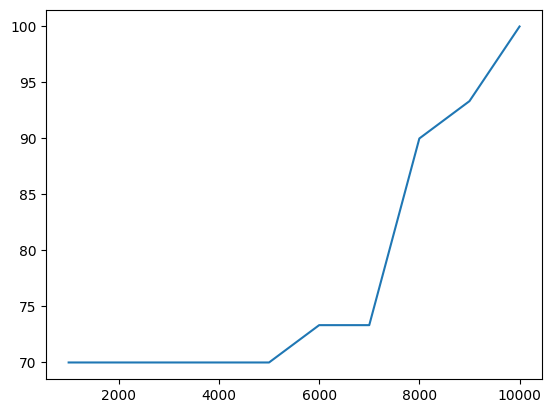

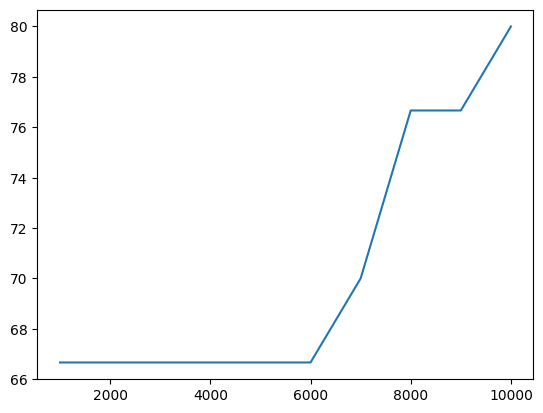

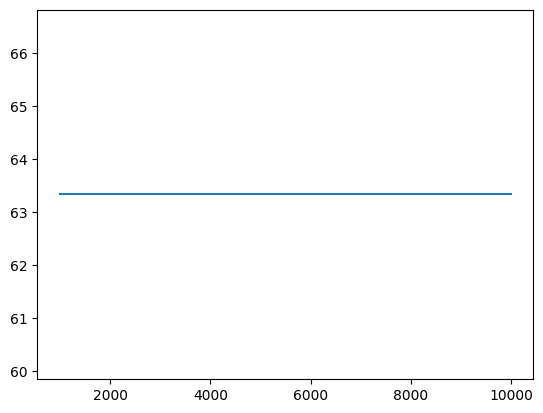

In [ ]:
#plotting the gradient descent

def prediction_logistic (x, w, b, decision_b):
  modelValue = np.dot(x, w) + b
  sigValue = c_sigmoid(modelValue)
  return (sigValue > decision_b)


y_validation_sentosa = classifierFunction(y_validation, CLASS_SENTOSA)
y_validation_versicolor = classifierFunction(y_validation, CLASS_VERSICOLOR)
y_validation_virginia = classifierFunction(y_validation, CLASS_VIRGINICA)

y_test_sentosa = classifierFunction(y_test, CLASS_SENTOSA)
y_test_versicolor = classifierFunction(y_test, CLASS_VERSICOLOR)
y_test_virginia = classifierFunction(y_test, CLASS_VIRGINICA)


decision_boundary = 0.5

def measureSuccessRate(trueSetX, trueSetY, w, b, decision_boundary):
  successCount = 0
  for validationRow in range(len(trueSetX)):
    testResult = prediction_logistic (trueSetX[validationRow], w, b, decision_boundary)
    if testResult == (trueSetY[validationRow]==1):
      successCount += 1
  return successCount, 100*successCount/len(trueSetX)




successRateSentosa = []
successRateVirginia = []
successRateVersicolor= []

for i in range(10):
  _, successPercentageSentosa = measureSuccessRate(X_validation, y_validation_sentosa, w_history_sentosa[i][0], w_history_sentosa[i][1], decision_boundary)
  _, successPercentageVirginia = measureSuccessRate(X_validation, y_validation_virginia, w_history_virginia[i][0], w_history_virginia[i][1], decision_boundary)
  _, successPercentageVersicolor = measureSuccessRate(X_validation, y_validation_versicolor, w_history_versicolor[i][0], w_history_versicolor[i][1], decision_boundary)
  successRateSentosa.append(successPercentageSentosa)
  successRateVirginia.append(successPercentageVirginia)
  successRateVersicolor.append(successPercentageVersicolor)


fig = plt.figure()
ax = plt.axes()
ax.plot( [1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000], successRateSentosa);
fig = plt.figure()
ax = plt.axes()
ax.plot( [1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000], successRateVirginia);
fig = plt.figure()
ax = plt.axes()
ax.plot( [1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000], successRateVersicolor);


